In [2]:
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.naive_bayes import BernoulliNB
from matplotlib import pyplot as plt
from typing import List
import io
import requests

In [3]:
%matplotlib inline
sns.set_style("darkgrid")

In [4]:
# df = pd.read_csv('heart_failure.csv')

url = 'https://raw.githubusercontent.com/casasmgb/curso-ml/main/02-section/mnist/train.csv'
data = requests.get(url).content
df_train = pd.read_csv(io.StringIO(data.decode('utf-8')))

url = 'https://raw.githubusercontent.com/casasmgb/curso-ml/main/02-section/mnist/test.csv'
data = requests.get(url).content
df_test = pd.read_csv(io.StringIO(data.decode('utf-8')))

In [5]:
df_train.head(5)

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [6]:
df_test.head(5)

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Preparacion de datos

In [7]:
x_train = df_train.drop('label', axis=1).to_numpy()
y_train = df_train['label'].to_numpy()
x_test = df_test.to_numpy()

In [8]:
y_train

array([1, 0, 1, ..., 7, 6, 9])

### Visualizacion de datos

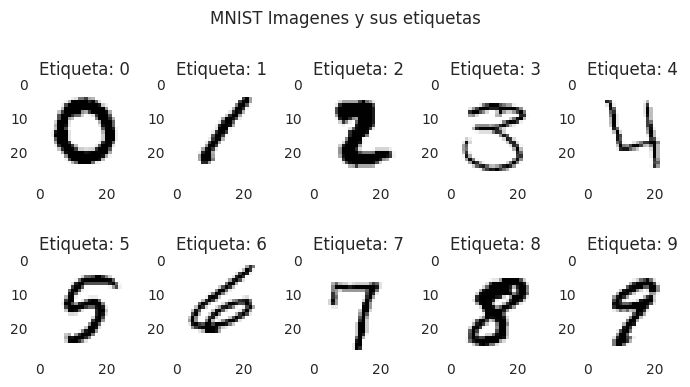

In [9]:

fig, ax = plt.subplots(2,5, figsize=(7,4))

for i, ax in enumerate(ax.flatten()):
    img_idx = np.argwhere(y_train == i)[0]
    img = np.reshape(x_train[img_idx], (28, 28))
    ax.imshow(img, cmap="gray_r")
    ax.set_title(f"Etiqueta: {i}")
    ax.grid(False)

fig.suptitle("MNIST Imagenes y sus etiquetas")

fig.tight_layout()

plt.show()


### Modificar los colores de las imagenes con el metodo THRESH_BINARY
![](https://b2633864.smushcdn.com/2633864/wp-content/uploads/2021/04/opencv_thresholding_opencvlogo.jpg?lossy=1&strip=1&webp=1)

In [10]:
x_train_binary: List = []

for i in x_train:
    img = np.reshape(i, (28, 28)).astype(np.uint8)
    # binarize
    im_gray = cv2.threshold(img, 120, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]
    x_train_binary.append(np.reshape(im_gray, (784,)))

x_train_binary = np.asarray(x_train_binary)

In [23]:
print(x_train[5])
print('============================================')
print(x_train_binary[5])

[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   3 141
 202 254 193  44   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   5 165 254 179 163 249 244  72   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0 135
 254 150   0   0 189 254 243  31   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0  82 248 209   5   0   0 164 236 254 115
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   8
 211 254  58   0   0   0   0  33 230 212   6   0   

### Crear el modelo

In [12]:
clf: BernoulliNB = BernoulliNB()

# create a KFold that returns stratified folds
skf = StratifiedKFold(n_splits=5)

# fit classifier on training set
scores = cross_val_score(clf, x_train_binary, y_train, cv=skf)

print(f"Accuracy: {scores.mean()}")



Accuracy: 0.8386190476190476


In [13]:

clf: BernoulliNB = BernoulliNB()
clf.fit(x_train_binary, y_train)
    

x_test_binary: List = []

for i in x_test:
    img: np.ndarray = np.reshape(i, (28, 28)).astype(np.uint8)
    im_gray: np.ndarray = cv2.threshold(img, 120, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]
    x_test_binary.append(np.reshape(im_gray, (784,)))

X_test_binary: np.ndarray = np.asarray(x_test_binary)     
    


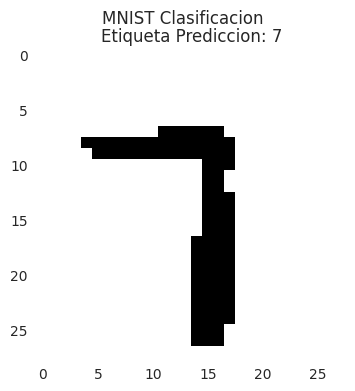

In [25]:
position = 264
y_pred = clf.predict([x_test_binary[position]])

fig, ax = plt.subplots(1,1, figsize=(7,4))
img = np.reshape(x_test_binary[position], (28, 28))
ax.imshow(img, cmap="gray_r")
ax.set_title(f"Etiqueta Prediccion: {y_pred[0]}")
ax.grid(False)

fig.suptitle("MNIST Clasificacion")

plt.show()